# Pylops-distributed - basic linear operators

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops-distributed*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse.linalg import lsqr
from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg

Local cluster

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=2,
                                               n_workers=2)
client

Client Scheduler: inproc://10.10.3.80/2816/1 Dashboard: http://localhost:53814/status,Cluster Workers: 2 Cores: 4 Memory: 8.59 GB


SSH cluster

In [3]:
#client = Client('be-linrgsn045:8786')
#client = pylops_distributed.utils.backend.dask(client='be-linrgsn045:8786')
#client

## Diagonal

Pylops

In [4]:
n = 100000
x = np.ones(n)
d = np.arange(n) + 1
Dop = pylops.Diagonal(d)
dottest(Dop, n, n, verb=True)

y  = Dop*x
y1 = Dop.H*y
xinv = Dop / y

print('D*x  = ',y)
print('D\'*x = ',y1)
print('D / y = ',xinv)

Dot test passed, v^T(Opu)=-14425394.825474 - u^T(Op^Tv)=-14425394.825474
D*x  =  [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  [4.09995980e-07 1.63998320e-06 3.68995950e-06 ... 9.99280430e-01
 9.99063740e-01 9.98822308e-01]


Pylops-distributed with lazy evaluation for forward and adjoint

In [5]:
xda = da.ones(n, chunks=(n//4,))
dda = da.from_array(d, chunks=(n//4,))

Ddaop = pylops_distributed.Diagonal(dda, compute=(False, False))
ddottest(Ddaop, n, n, chunks=(n//4, n//4), verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop.div(yda, niter=5)

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda, yda.compute())
print('D\'*x = ',y1da, y1da.compute())
print('D / y = ',xinvda, xinvda.compute())

Dot test passed, v^T(Opu)=1248045219.927985 - u^T(Op^Tv)=1248045219.927985
Diagonal >  dask.array<array, shape=(100000,), dtype=int64, chunksize=(25000,)>
D*x  =  dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  dask.array<add, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.49998500e-09 5.99994000e-09 1.34998650e-08 ... 1.08508832e+00
 1.08515221e+00 1.08521612e+00]


In [6]:
xda

dask.array<ones, shape=(100000,), dtype=float64, chunksize=(25000,)>

In [7]:
Ddaop

<100000x100000 Diagonal with dtype=float64>

In [8]:
yda.persist()

dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)>

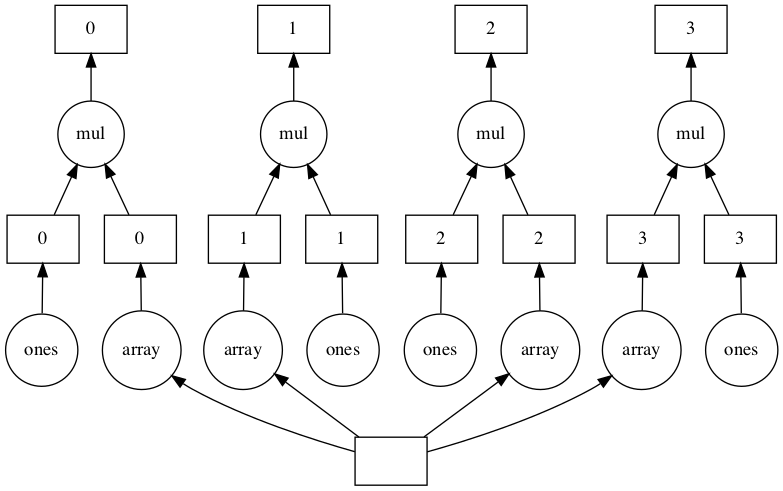

In [9]:
yda.visualize()

In [10]:
# invda.visualize()

Pylops-distributed with compute for forward and adjoint

In [11]:
xda = da.ones(n, chunks=(n//4,))
dda = da.from_array(d, chunks=(n//4,))
True
Ddaop = pylops_distributed.Diagonal(dda, compute=(True, True))
dottest(Ddaop, n, n, verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop.div(yda, niter=10)

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda)
print('D\'*x = ',y1da)
print('D / y = ',xinvda)

Dot test passed, v^T(Opu)=23270536.805332 - u^T(Op^Tv)=23270536.805332
Diagonal >  dask.array<array, shape=(100000,), dtype=int64, chunksize=(25000,)>
D*x  =  [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  [4.99995001e-09 1.99997999e-08 4.49995495e-08 ... 9.64968641e-01
 9.64880728e-01 9.64792708e-01]


Comparision

In [12]:
%timeit -n 10 -r 3 Dop.matvec(x)
%timeit -n 10 -r 3 Ddaop.matvec(xda)

748 µs ± 105 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
11.5 ms ± 409 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


Finally we do the same with multiple dimensions

In [13]:
nother = 500

# serial
Dop = pylops.Diagonal(d, dir=1, dims=(nother, n))
print('Diagonal > ', Dop.diag)

x = np.ones((nother, n))
y = (Dop*x.flatten()).reshape(nother, n)
print('D*x  = \n',y)

# distributed
Ddaop = pylops_distributed.Diagonal(dda, dir=1, dims=(nother, n))
print('Diagonal > ', Ddaop.Op.diag)

xda = da.ones((nother, n), chunks=(nother, n//4))
yda = Ddaop.matvec(xda.flatten())
print('D*x  = ',y,'\n', yda.compute().reshape(nother, n))

Diagonal >  [[     1      2      3 ...  99998  99999 100000]]
D*x  = 
 [[1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 ...
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]]
Diagonal >  dask.array<reshape, shape=(1, 100000), dtype=int64, chunksize=(1, 25000)>
D*x  =  [[1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 ...
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+

In [14]:
xda

dask.array<ones, shape=(500, 100000), dtype=float64, chunksize=(500, 25000)>

In [15]:
%timeit -n 3 -r 2 Dop.matvec(x.ravel())
%timeit -n 3 -r 2 Ddaop.matvec(xda.ravel()).compute()

1.05 s ± 130 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
2.51 s ± 7.96 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


## Restriction

Pylops

In [16]:
# Signal creation
freqs = [ 5., 3., 8.]

N=200
dt=0.004
t = np.arange(N)*dt
x = np.zeros(N)

for freq in freqs:
    x = x + np.sin(2*np.pi*freq*t)
    
# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

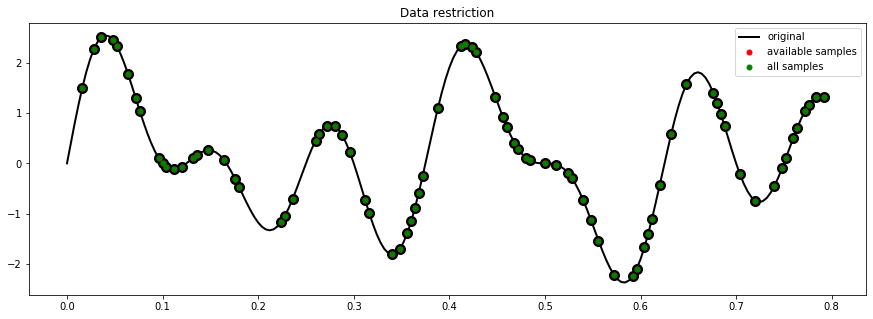

In [17]:
# Create restriction operator
Rop = pylops.Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y = Rop*x
xadj = Rop.H*y
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , LineWidth=2,   label='original')
plt.plot(t[iava], x[iava], '.k', MarkerSize=20)
plt.plot(t[iava], y,       '.r', MarkerSize=10, label='available samples')
plt.plot(t,       ymask,   '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

Pylops-distributed

In [18]:
dRop = pylops_distributed.Restriction(N, iava, dtype='float64', compute=(False, False))
ddottest(dRop, Nsub, N, chunks=(Nsub//4, N//4), verb=True)

xda = da.from_array(x, chunks=(N//4,))
yda = dRop * xda
xadjda = dRop.H * yda

Dot test passed, v^T(Opu)=21.785208 - u^T(Op^Tv)=21.785208


Let's do that in 2d

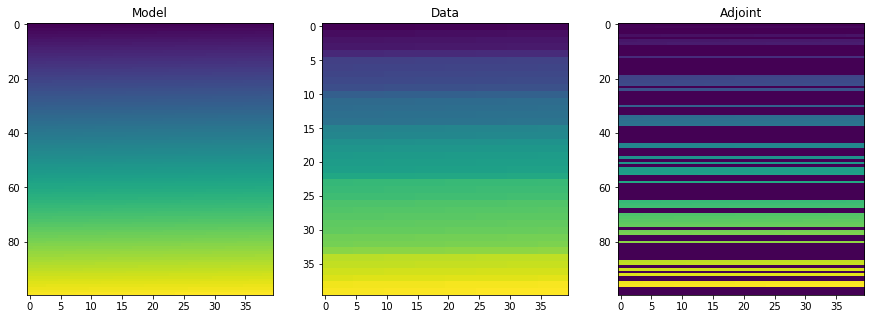

In [19]:
nz, nx = 100, 40

# subsampling locations
perc_subsampling = 0.4
nzsub = int(np.round(nz*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(nz))[:nzsub])

x = np.arange(nz*nx).reshape(nz, nx)

# Create restriction operator
Rop = pylops.Restriction(nz*nx, iava, dims=(nz, nx), dir=0, dtype='float64')
dottest(Rop, nzsub*nx, nz*nx)

y = Rop*x.ravel()
xadj = Rop.H*y
ymask = Rop.mask(x.ravel())

y = y.reshape(nzsub, nx)
xadj = xadj.reshape(nz, nx)
ymask = ymask.reshape(nz, nx)

# Visualize data
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(x)
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(y)
axs[1].axis('tight')
axs[1].set_title('Data');
axs[2].imshow(xadj)
axs[2].axis('tight')
axs[2].set_title('Adjoint');

Dot test passed, v^T(Opu)=402.030622 - u^T(Op^Tv)=402.030622


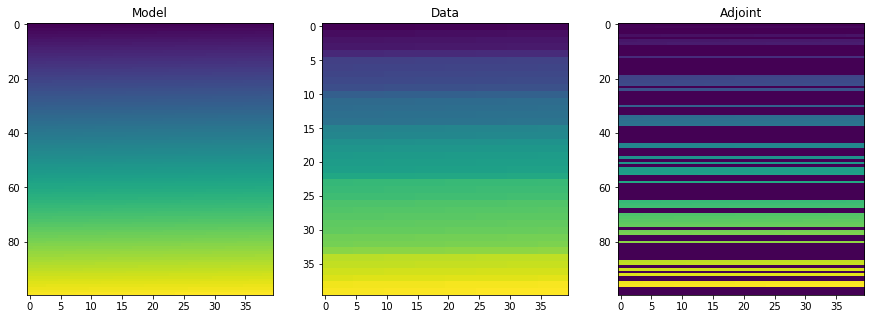

In [20]:
dRop = pylops_distributed.Restriction(nz*nx, iava, dims=(nz, nx), dir=0,
                                      dtype='float64', compute=(False, False))
ddottest(dRop, nzsub*nx, nz*nx, chunks=(nzsub*nx//4, nz*nx//4), verb=True)

xda = da.from_array(x, chunks=(nz//4, nx//4))
yda = dRop * xda.ravel()
xadjda = dRop.H * yda

yda = yda.reshape(nzsub, nx)
xadjda = xadjda.reshape(nz, nx)

# Visualize data
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(xda)
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(yda)
axs[1].axis('tight')
axs[1].set_title('Data');
axs[2].imshow(xadjda)
axs[2].axis('tight')
axs[2].set_title('Adjoint');

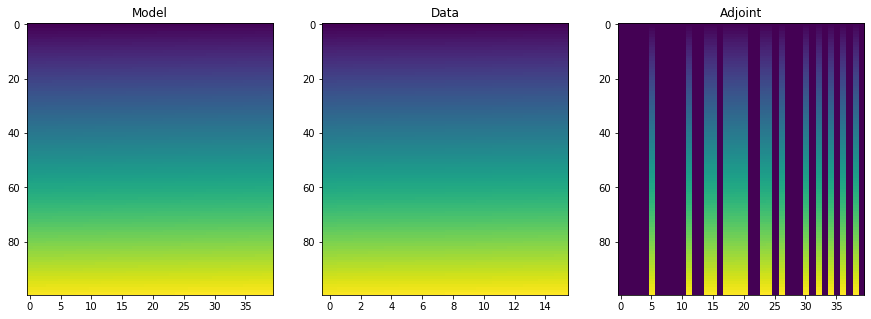

In [21]:
nz, nx = 100, 40

# subsampling locations
perc_subsampling = 0.4
nxsub = int(np.round(nx*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(nx))[:nxsub])

x = np.arange(nz*nx).reshape(nz, nx)

# Create restriction operator
Rop = pylops.Restriction(nz*nx, iava, dims=(nz, nx), dir=1, dtype='float64')
dottest(Rop, nz*nxsub, nz*nx)

y = Rop*x.ravel()
xadj = Rop.H*y
ymask = Rop.mask(x.ravel())

y = y.reshape(nz, nxsub)
xadj = xadj.reshape(nz, nx)
ymask = ymask.reshape(nz, nx)

# Visualize data
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(x)
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(y)
axs[1].axis('tight')
axs[1].set_title('Data')
axs[2].imshow(xadj)
axs[2].axis('tight')
axs[2].set_title('Adjoint');

Dot test passed, v^T(Opu)=406.648142 - u^T(Op^Tv)=406.648142


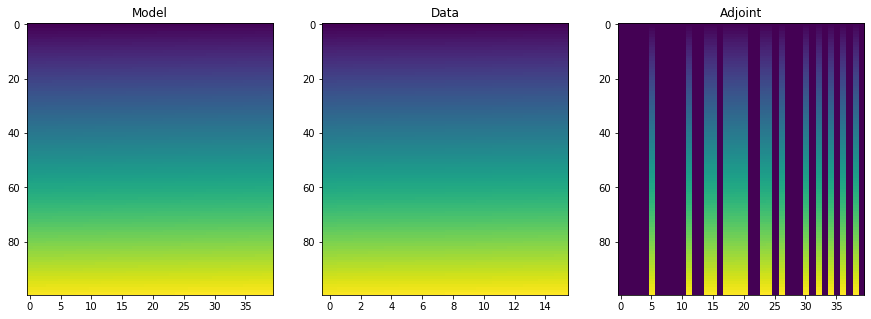

In [22]:
dRop = pylops_distributed.Restriction(nz*nx, iava, dims=(nz, nx), dir=1,
                                      dtype='float64', compute=(False, False))
ddottest(dRop, nz*nxsub, nz*nx, chunks=(nz*nxsub//4, nz*nx//4), verb=True)

xda = da.from_array(x, chunks=(nz//4, nx//4))
yda = dRop * xda.ravel()
xadjda = dRop.H * yda

yda = yda.reshape(nz, nxsub)
xadjda = xadjda.reshape(nz, nx)

# Visualize data
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(xda)
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(yda)
axs[1].axis('tight')
axs[1].set_title('Data')
axs[2].imshow(xadjda)
axs[2].axis('tight')
axs[2].set_title('Adjoint');